# Sentinel-3 zarr products

In [1]:
using CopernicusData
using CairoMakie
using GeoMakie
using Downloads

const PRODUCT_PATH = "https://common.s3.sbg.perf.cloud.ovh.net/eoproducts"
const OLCEFR="S03OLCEFR_20230506T015316_0180_B117_T883.zarr.zip"

"S03OLCEFR_20230506T015316_0180_B117_T883.zarr.zip"

## OLCI Level-1

In [2]:
olci_path = joinpath(PRODUCT_PATH, OLCEFR)
olci_path

"https://common.s3.sbg.perf.cloud.ovh.net/eoproducts/S03OLCEFR_20230506T015316_0180_B117_T883.zarr.zip"

In [3]:
local_path = joinpath(tempdir(),OLCEFR)
# Downloads.download(olci_path, local_path)
efr = open_datatree(local_path)
efr

📂 root
├─ 📂 conditions
├─ ├─ 📂 geometry
├─ ├─ 📂 image
├─ ├─ 📂 instrument
├─ ├─ 📂 meteorology
├─ └─ 📂 orphans
├─ 📂 measurements
├─ └─ 📂 orphans
└─ 📂 quality
└─ └─ 📂 orphans


The product is represented by a hierarchical tree structure `YAXTrees.YAXTree`


### Opening measurements data


In [4]:
rad = efr.measurements.oa01_radiance
rad

┌ 4865×4092 YAXArray{Union{Missing, Float64}, 2} ┐
├────────────────────────────────────────────────┴─────────────────────── dims ┐
  ↓ columns Sampled{Int64} 1:4865 ForwardOrdered Regular Points,
  → rows    Sampled{Int64} 1:4092 ForwardOrdered Regular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Dict{String, Any} with 12 entries:
  "long_name"     => "TOA radiance for OLCI acquisition band oa01"
  "scale_factor"  => 0.0136349
  "name"          => "oa01_radiance"
  "add_offset"    => 0.0
  "standard_name" => "toa_upwelling_spectral_radiance"
  "valid_min"     => 0
  "valid_max"     => 65534
  "coordinates"   => "time_stamp latitude longitude"
  "_FillValue"    => 0xffff
  "units"         => "mW.m-2.sr-1.nm-1"
  "short_name"    => "oa01_radiance"
  "missing_value" => 0xffff
├─────────────────────────────────────────────────────────────── loaded lazily ┤
  data size: 151.88 MB
└─────────────────────────────────────────────────────────────────

The nodes of the `YAXTree` are `YAXArrays.YAXArray` or `YAXArrays.Dataset`

The underlying data is a `CFDiskArray`

### Plot data

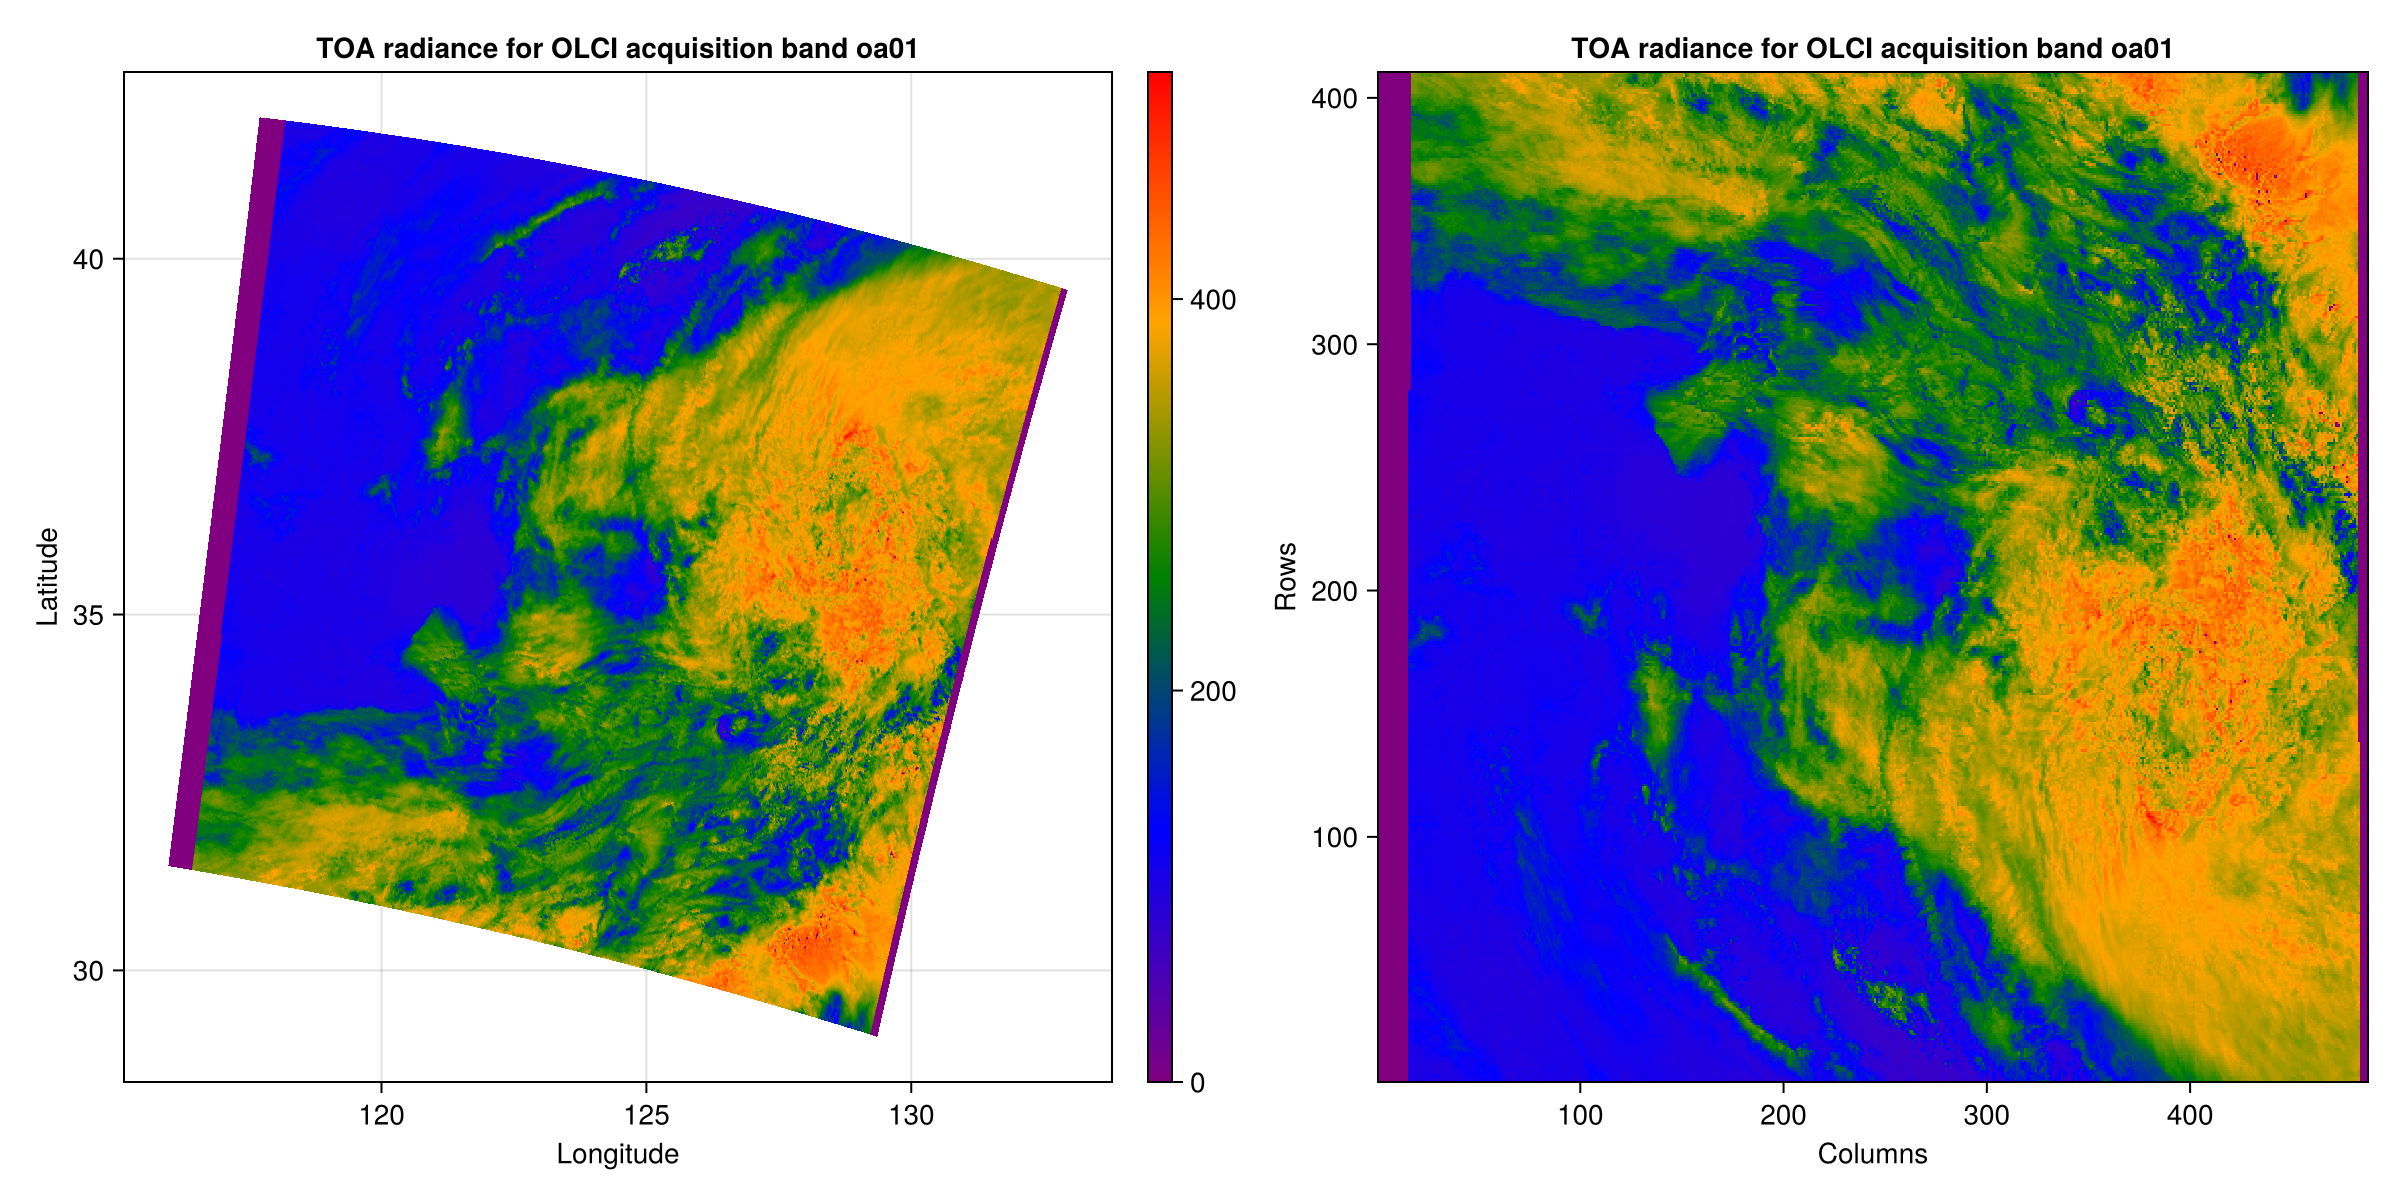

In [19]:
latitude=efr.measurements.latitude
longitude=efr.measurements.longitude

step=10
lon=longitude.data[1:step:end,1:step:end]
lat=latitude.data[1:step:end,1:step:end]
val=replace(rad.data[1:step:end,1:step:end], missing => 0.0)
min,max = minimum(skipmissing(val)), maximum(skipmissing(val))

fig=Figure(size=(1200,600))
ax1=Axis(fig[1, 1], title=rad.properties["long_name"],
     xlabel="Longitude", ylabel="Latitude")
s=surface!(ax1,lon, lat, zeros(size(lon));
     color=val,colorrange=(min,max),colormap=:rainbow, shading=NoShading)
     Colorbar(fig[1, 2], s)
ax2=Axis(fig[1, 3], title=rad.properties["long_name"],
     xlabel="Columns", ylabel="Rows")
heatmap!(ax2, val, colormap=:rainbow, colorrange=(min,max))
fig

### Open meteorological conditions

In [7]:

meteo = efr.conditions.meteorology

📂 meteorology


### Interpolate the atmospheric temperature at p=832.2 hPa

In [14]:
x=getproperty(meteo.atmospheric_temperature_profile,:pressure_level)

pressure_level Sampled{Float32} ReverseOrdered Irregular DimensionalData.Dimensions.Lookups.Points
wrapping: 25-element Vector{Float32}:
 1000.0
  950.0
  925.0
  900.0
  850.0
  800.0
  700.0
  600.0
  500.0
  400.0
    ⋮
   50.0
   30.0
   20.0
   10.0
    7.0
    5.0
    3.0
    2.0
    1.0

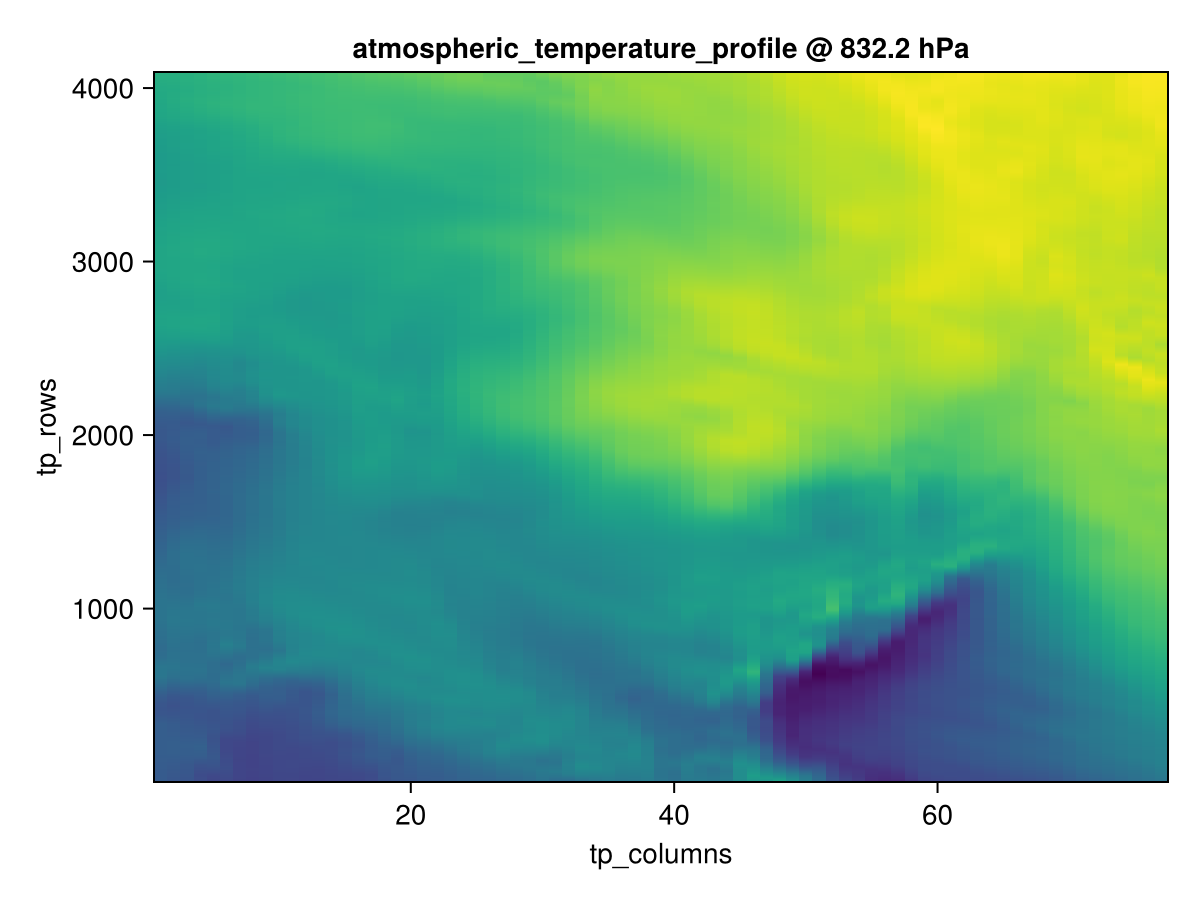

In [20]:
tp = linear_interpolation(meteo, "atmospheric_temperature_profile", dims="pressure_level", value=832.2)
fig=Figure()
ax=Axis(fig[1, 1], title="atmospheric_temperature_profile @ 832.2 hPa",
     xlabel="tp_columns", ylabel="tp_rows")
heatmap!(ax,tp.data)
fig